In [1]:
import warnings
warnings.simplefilter("ignore")

# Statistics in Python: an introduction

In part adapted from: 
* Gaël Varoquaux [Scipy Lecture](https://scipy-lectures.org/packages/statistics/index.html#linear-models-multiple-factors-and-analysis-of-variance)
* The fMRI course developed by M. Brett and myself
* Many other resources


## Requirements
1. Standard scientific Python environment (numpy, scipy, matplotlib)
2. Pandas
3. [Statsmodels](https://www.statsmodels.org/stable/index.html)
4. [Seaborn](https://seaborn.pydata.org/)

**Disclaimer: Gender questions**

   Some of the examples of this tutorial are chosen around gender 
    questions. The reason is that on such questions controlling the truth
    of a claim actually matters to many people. 


## What this will not cover

* **Bayesian statistics in Python**:

    This chapter does not cover tools for Bayesian statistics.  
    Of particular interest for Bayesian modelling is 
    [PyMC](http://pymc-devs.github.io/pymc),  
    which implements a probabilistic programming language in Python.

* **Permutation testing** (see sklearn)

* **Read a statistics book**:
   The [Think stats](http://greenteapress.com/wp/think-stats-2e>)  
   book is available as free PDF or in print and is a great 
   introduction to statistics.

Data representation and interaction
====================================

Data as a table
---------------------

The setting that we consider for statistical analysis is that of multiple
*observations* or *samples* described by a set of different *attributes*
or *features*. The data can than be seen as a 2D table, or matrix, with
columns giving the different attributes of the data, and rows the
observations. For instance, the data contained in
[This csv file](https://raw.githubusercontent.com/scipy-lectures/scipy-lecture-notes/master/packages/statistics/examples/brain_size.csv)


The data in this .csv file looks like:
```
"";"Gender";"FSIQ";"VIQ";"PIQ";"Weight";"Height";"MRI_Count"
"1";"Female";133;132;124;"118";"64.5";816932
"2";"Male";140;150;124;".";"72.5";1001121
"3";"Male";139;123;150;"143";"73.3";1038437
"4";"Male";133;129;128;"172";"68.8";965353
"5";"Female";137;132;134;"147";"65.0";951545
```

## The pandas data-frame


We will store and manipulate this data in a
    `pandas.DataFrame`, from the [pandas](http://pandas.pydata.org) module. It is the Python equivalent of
    the spreadsheet table. It is different from a 2D ``numpy`` array as it
    has named columns, can contain a mixture of different data types by
    column, and has elaborate selection and pivotal mechanisms.


### Creating dataframes: reading data files or converting arrays



In [2]:
import pandas

csvfile = ('https://raw.githubusercontent.com/scipy-lectures/'
          'scipy-lecture-notes/master/packages/statistics/examples/brain_size.csv')

data = pandas.read_csv(csvfile, sep=';', index_col=0)

data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
1,Female,133,132,124,118,64.5,816932
2,Male,140,150,124,.,72.5,1001121
3,Male,139,123,150,143,73.3,1038437
4,Male,133,129,128,172,68.8,965353
5,Female,137,132,134,147,65.0,951545


In [3]:
print('What type is data ? : ', type(data))
print("It stores values in a numpy array:", type(data.values))
data.values[:5]

What type is data ? :  <class 'pandas.core.frame.DataFrame'>
It stores values in a numpy array: <class 'numpy.ndarray'>


array([['Female', 133, 132, 124, '118', '64.5', 816932],
       ['Male', 140, 150, 124, '.', '72.5', 1001121],
       ['Male', 139, 123, 150, '143', '73.3', 1038437],
       ['Male', 133, 129, 128, '172', '68.8', 965353],
       ['Female', 137, 132, 134, '147', '65.0', 951545]], dtype=object)

### warning: Missing values


The weight of the second individual is missing in the CSV file. In this
  particular file, missing values are represented by "`.`". If we don't specify
  the missing value (NA = not available) marker, pandas will not recognize this
  and we will not be able to do statistical analysis.


In [4]:
data = pandas.read_csv(csvfile, sep=';', na_values=".")
data.head(5) #.dropna()

,Unnamed: 0,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,1,Female,133,132,124,118.0,64.5,816932
1,2,Male,140,150,124,NaN,72.5,1001121
2,3,Male,139,123,150,143.0,73.3,1038437
3,4,Male,133,129,128,172.0,68.8,965353
4,5,Female,137,132,134,147.0,65.0,951545


## Creating from arrays

A `pandas.DataFrame` can also be seen as a dictionary of 1D 'series', eg arrays or lists. If we have 3
``numpy`` arrays:

In [5]:
import numpy as np
t = np.linspace(-6, 6, 20)
sin_t = np.sin(t)
cos_t = np.cos(t)

# We can expose them as a :class:`pandas.DataFrame`::
pandas.DataFrame({'t': t, 'sin': sin_t, 'cos': cos_t}).head(4)

# Question : what is the first argument ? 

,t,sin,cos
0,-6.000000,0.279415,0.960170
1,-5.368421,0.792419,0.609977
2,-4.736842,0.999701,0.024451
3,-4.105263,0.821291,-0.570509


## Manipulating data


In [6]:
print('data.shape: ', data.shape)
print('data.columns: ',data.columns)  # It has columns
print('\nFemale VIQ mean: ', data[data['Gender'] == 'Female']['VIQ'].mean())

data.describe()

data.shape:  (40, 8)
data.columns:  Index(['Unnamed: 0', 'Gender', 'FSIQ', 'VIQ', 'PIQ', 'Weight', 'Height',
       'MRI_Count'],
      dtype='object')

Female VIQ mean:  109.45


,Unnamed: 0,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,40.000000,40.000000,40.000000,40.00000,38.000000,39.000000,4.000000e+01
mean,20.500000,113.450000,112.350000,111.02500,151.052632,68.525641,9.087550e+05
std,11.690452,24.082071,23.616107,22.47105,23.478509,3.994649,7.228205e+04
min,1.000000,77.000000,71.000000,72.00000,106.000000,62.000000,7.906190e+05
25%,10.750000,89.750000,90.000000,88.25000,135.250000,66.000000,8.559185e+05
50%,20.500000,116.500000,113.000000,115.00000,146.500000,68.000000,9.053990e+05
75%,30.250000,135.500000,129.750000,128.00000,172.000000,70.500000,9.500780e+05
max,40.000000,144.000000,150.000000,150.00000,192.000000,77.000000,1.079549e+06


In [7]:
# Question: Will we get the same results with : 
# `data.dropna().describe()` ?

In [8]:
# "Group by"
groupby_gender = data.groupby('Gender')
for gender, value in groupby_gender['VIQ']:
    print((gender, value.mean()))

('Female', 109.45)
('Male', 115.25)


In [9]:
tmp = groupby_gender.get_group("Female")
tmp.head()
#groupby_gender.head(7)
#[print(item) for item in groupby_gender]

,Unnamed: 0,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,1,Female,133,132,124,118.0,64.5,816932
4,5,Female,137,132,134,147.0,65.0,951545
5,6,Female,99,90,110,146.0,69.0,928799
6,7,Female,138,136,131,138.0,64.5,991305
7,8,Female,92,90,98,175.0,66.0,854258


In [10]:
type(groupby_gender)

pandas.core.groupby.generic.DataFrameGroupBy

In [11]:
data.loc[data['Gender'] == 'Female', 'VIQ'] += 1

In [12]:
for gender, value in groupby_gender['VIQ']:
    print((gender, value.mean()))

data['VIQ'] += 1

# Question : what if we look at the groupby_gender object ? 

('Female', 110.45)
('Male', 115.25)


In [13]:
for gender, value in groupby_gender['VIQ']:
    print((gender, value.mean()))

('Female', 111.45)
('Male', 116.25)


* What is the mean value for VIQ for the full population?
* How many males/females were included in this study?

  **Hint** use 'tab completion' to find out the methods that can be
  called, instead of 'mean' in the above example.

* What is the average value of MRI counts expressed in log units, for
  males and females?


## Plotting data


In [16]:
from pandas import plotting as pdplt


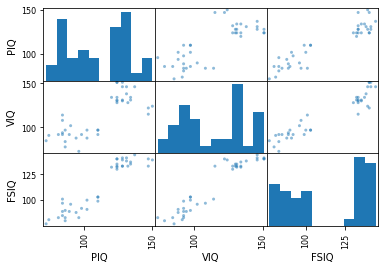

In [17]:
pdplt.scatter_matrix(data[['PIQ', 'VIQ', 'FSIQ']]);

The IQ metrics are bimodal, as if there are 2 sub-populations.

# Hypothesis testing: comparing two groups


For simple statistical tests:

https://en.wikipedia.org/wiki/Statistical_hypothesis_testing

we will use the `scipy.stats` sub-module of [scipy](http://docs.scipy.org/doc/)



In [18]:
from scipy import stats
from scipy import stats as sst

Cohen's d effect size : 

$\hspace{3cm} d = \frac{\mu}{\sigma}$

$\mu$ the non normalized effect size, $\sigma$ the standard deviation of the **data**

Author report: APOE effect on hippocampal volume has a p value of 6.6311e-10, n=733
What is the effect size of APOE on the hippocampal volume ?


In [19]:
# create a normal(0,1) variable 
n01 = sst.norm(0,1.)
# n01 = sst.t(df=733)

z = n01.isf(6.6311e-10)

#wat = n01.cdf(6.6311e-10)

d = n01.isf(6.6311e-10)/np.sqrt(733)
print("z = {:4.3f} d = {:4.3f}".format(z,d))

z = 6.064 d = 0.224


In [ ]:
n01.rvs(size=(3,3))

In [ ]:
# scipy stats has a great number of distribution, all with pdf cdf, sf, isf, etc ...  
# but you can also sample from these: 
n, start, width = 1000, 10, 20
unif10_20 = sst.uniform(loc=start,scale=width)
data_uniform = unif10_20.rvs(size=(n,))

import seaborn as sns
ax = sns.distplot(data_uniform,
                  bins=50,
#                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

![title](stats-distrib.png)

## Student's t-test: the simplest statistical test


`scipy.stats.ttest_1samp` tests if the population mean of data is
likely to be equal to a given value (technically if observations are
drawn from a Gaussian distributions of given population mean). It returns
the [T statistic](https://en.wikipedia.org/wiki/Student%27s_t-test),
and the [p-value](https://en.wikipedia.org/wiki/P-value) (see the
function's help)

In [ ]:
stats.ttest_1samp(data['VIQ'], 0)

### Definition of a p-value


Probability of observing a statistic equal to the one seen 
in the data, or one that is more extreme, when the null 
hypothesis is true


Requires:
* Knowledge of the null hypothesis
* Choice of a statistic
* Concept of repeating the whole study in the same way
    - Same study design
    - Same sampling scheme
    - Same definition of the statistic

### 2-sample t-test: testing for difference across populations

We have seen above that the mean VIQ in the  male and  
female populations were different. To test if this is  
significant, we do a 2-sample t-test with  

`scipy.stats.ttest_ind`



In [ ]:
np.set_printoptions(precision=4) # he non !

female_viq = data[data['Gender'] == 'Female']['VIQ']
male_viq = data[data['Gender'] == 'Male']['VIQ']
stats.ttest_ind(female_viq, male_viq)   

#stats.ttest_ind?

### Paired tests: repeated measurements on the same individuals

PIQ, VIQ, and FSIQ give 3 measures of IQ.  
Let us test if FISQ and PIQ are significantly  
different. We can use a 2 sample test


In [ ]:
# Box plots of different columns for each gender
groupby_gender.boxplot(column=['FSIQ', 'VIQ', 'PIQ'])
groupby_gender.groups

In [ ]:
stats.ttest_ind(data['FSIQ'], data['PIQ'])

# Can you see a problem with this approach ?

The problem with this approach is that it forgets that there are links between  
observations: FSIQ and PIQ are measured on the same individuals. Thus the  
variance due to inter-subject variability is confounding, and can be removed,  
using a "paired test", or ["repeated measures test"](https://en.wikipedia.org/wiki/Repeated_measures_design)  

In [ ]:
# considering that FSIQ and PIQ come from the same participants:

stats.ttest_rel(data['FSIQ'], data['PIQ'])

In [ ]:
# This is equivalent to a 1-sample test on the difference:

stats.ttest_1samp(data['FSIQ'] - data['PIQ'], 0)

# stats.ttest_1samp?

T-tests assume Gaussian errors.  

We can use a [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) that relaxes this assumption:


In [ ]:
stats.wilcoxon(data['FSIQ'], data['PIQ'])

### Exercise

* Test the difference between weights in males and females.
* Use non parametric statistics to test the difference  
  between VIQ in males and females.

In [ ]:
import pandas
from statsmodels.formula.api import ols

data = pandas.read_csv(csvfile, sep=';', na_values='.')

model = ols('VIQ ~ Gender + MRI_Count + Height', data).fit()
print(model.summary())

# Here, we don't need to define a contrast, as we are testing a single
# coefficient of our model, and not a combination of coefficients.
# However, defining a contrast, which would then be a 'unit contrast',
# will give us the same results
print(model.f_test([0, 1, 0, 0]))

In [ ]:
###############################################################################
# Here we plot a scatter matrix to get intuitions on our results.
# This goes beyond what was asked in the exercise

# This plotting is useful to get an intuitions on the relationships between
# our different variables

from pandas import plotting
import matplotlib.pyplot as plt

# Fill in the missing values for Height for plotting
data['Height'].fillna(method='pad', inplace=True)

# The parameter 'c' is passed to plt.scatter and will control the color
# The same holds for parameters 'marker', 'alpha' and 'cmap', that
# control respectively the type of marker used, their transparency and
# the colormap
plotting.scatter_matrix(data[['VIQ', 'MRI_Count', 'Height']],
                        c=(data['Gender'] == 'Female'), marker='o',
                        alpha=1, cmap='winter')

fig = plt.gcf()
fig.suptitle("blue: male, green: female", size=13)

plt.show()

# Linear models, multiple factors, and analysis of variance

## "formulas" to specify statistical models in Python

### A simple linear regression


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Generate and show the data
x = np.linspace(-5, 5, 20)

# To get reproducible values, provide a seed value
np.random.seed(1)

y = -5 + 3*x + 4 * np.random.normal(size=x.shape)

# Plot the data
plt.figure(figsize=(5, 4))
plt.plot(x, y, 'o')

In [ ]:
#############################################################
# Multilinear regression model, calculating fit, P-values,
# confidence intervals etc.

# Convert the data into a Pandas DataFrame to use the formulas 
# framework in statsmodels
data = pandas.DataFrame({'x': x, 'y': y})

# Fit the model
model = ols("y ~ x", data).fit()

# Print the summary
print(model.summary())

In [ ]:
# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

#print('\nANOVA results')
print(anova_results)

Statsmodels uses a statistical terminology: the `y` variable in
statsmodels is called 'endogenous' while the `x` variable is called
exogenous.  This is discussed in more detail in  
http://statsmodels.sourceforge.net/devel/endog_exog.html

To simplify, `y` (endogenous) is the value you are trying to predict,
while `x` (exogenous) represents the features you are using to make
the prediction.


Retrieve the estimated parameters from the model above. 


   **Hint**: use tab-completion to find the relevent attribute.


In [ ]:
# model.model.exog

## Categorical variables: comparing groups or multiple categories


In [ ]:
# remember, we modified "data" !
data = pandas.read_csv(csvfile, sep=';', na_values=".")

In [ ]:
model = ols("VIQ ~ Gender + 1", data)
modelfit = model.fit()
print(modelfit.summary())

In [ ]:
model.exog_names

**Forcing categorical**:

the 'Gender' is automatically detected as a
categorical variable, and thus each of its different values are
treated as different entities.

An integer column can be forced to be treated as categorical using:

    model = ols('VIQ ~ C(Gender)', data).fit()


**Intercept**:

We can remove the intercept using `- 1` in the formula,
or force the use of an intercept using `+ 1`.


By default, statsmodels treats a categorical variable with K possible
values as K-1 'dummy' boolean variables (the last level being
absorbed into the intercept term).  This is almost always a good
default choice - however, it is possible to specify different
encodings for categorical variables
(http://statsmodels.sourceforge.net/devel/contrasts.html).



**Link to t-tests between different FSIQ and PIQ**

In [ ]:
# To compare different types of IQ, we need to create a "long-form"
# table, listing IQs, where the type of IQ is indicated by a
# categorical variable::

data_fisq = pandas.DataFrame({'iq': data['FSIQ'], 'type': 'fsiq'})
data_piq = pandas.DataFrame({'iq': data['PIQ'], 'type': 'piq'})
data_long = pandas.concat((data_fisq, data_piq))

print(data_long)

#some_rows = (np.random.random_sample(data_long.shape[0]) < .15)
#print(data_long.loc[some_rows, 'type'])

In [ ]:
model = ols("iq ~ type", data_long).fit()
print(model.summary())

In [ ]:
# same values 
stats.ttest_ind(data['PIQ'], data['FSIQ']) 


 Going back to the brain size + IQ data, test if the VIQ of male and
 female are different after removing the effect of brain size, height
   and weight.
```

In [ ]:
data = pandas.read_csv(csvfile, sep=';', na_values=".")
data.columns

In [ ]:
modelfit = ols("VIQ ~ Weight + Height + MRI_Count + Gender", data).fit()
modelfit.summary()

In [ ]:
modelfit = ols("VIQ ~ Weight + Height + MRI_Count*Gender - 1", data).fit()
modelfit.summary()

In [ ]:
print(modelfit.f_test([1, -1, 0, 0, 0, 0]))
print(modelfit.f_test([[0, 0, 1, 0, 0, 0],[0, 0, 0, 1, 0, 0]]))  

In [ ]:
#modelfit.model.exog

# Investigating the Winner's curse effect

## Simulate one experiment  
* n samples, alpha type I error, normal distribution, mean, sigma are parameters (start with parameters: 'n':30, 'mu':.25, 'sigma': 1., 'alpha': 0.05)
* test if the mean of the simulated sample is equal to zero (our null hypothesis) controlling for the type I error

## Simulate N_exp experiments
* launch N_exp of these simulations
* record the results - if the test is significant, store the mean of the sample in a numpy array named `published`
* compare original mean (eg. 25) with the `published` values

## What if ...
* n sample is smaller ?
* alpha is more strict ?
* effect size (the mean of the normal) is greater ? smaller ?


# Robust statistics with statsmodel

In [ ]:
import statsmodels.api as sm
#data = sm.datasets.stackloss.load()
data = modelfit.model
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(hub_results.summary(yname='y', xname=data.exog_names))
#           xname=['var_{:d}'.format(i) for i in range(len(hub_results.params))]))

In [ ]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.asarray([x1, (x1-5)**2]).T
X = sm.add_constant(X)
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample

In [ ]:
modelfit = sm.OLS(y2, X).fit()
print(modelfit.params)
print(modelfit.bse)
# print(modelfit.predict() - y2)

In [ ]:
modelfit_rlm = sm.RLM(y2, X).fit()
print(modelfit_rlm.params)
print(modelfit_rlm.bse)

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
predict_std, conf_lower, conf_upper = wls_prediction_std(modelfit)

ax.plot(x1, modelfit.fittedvalues, 'r-', label="OLS")
ax.plot(x1, conf_upper, 'r--')
ax.plot(x1, conf_lower, 'r--')
ax.plot(x1, modelfit_rlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

In [ ]:
#wls_prediction_std?

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# Correlated regressors

Load and configure libraries: